# 141C Final Project – Predict Text Complexity
Quilvio Hernandez, Xing Yang Lan, Aditya Kallepalli

Inspirations:
- [Guide to learn NLP](https://www.kaggle.com/donmarch14/commonlit-detailed-guide-to-learn-nlp)
- [Clean Visualizations](https://www.kaggle.com/gaetanlopez/how-to-make-clean-visualizations)
- [Understanding the Competition](https://www.kaggle.com/heyytanay/commonlit-eda-understanding-the-competition)

## Libraries

In [1]:
# Array Support packages
import numpy as np
import pandas as pd

# Progress bar
# https://tqdm.github.io/docs/notebook/
from tqdm.notebook import tqdm

# Helper packages
import string
import time
import math
import re
from random import randint
from collections import Counter

# sci-kit learn functions for Linear Models
# https://scikit-learn.org/stable/
from sklearn.model_selection import StratifiedKFold
from sklearn.pipeline import make_pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import ElasticNet, LinearRegression, Lasso, Ridge
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV

# TF functions for NN models
# https://www.tensorflow.org/
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler, ReduceLROnPlateau
from tensorflow.keras.metrics import RootMeanSquaredError
# https://www.tensorflow.org/tutorials/keras/keras_tuner
import keras_tuner as kt

# NLP packages
# https://www.nltk.org/
import nltk
# nltk.download()
from nltk.stem.snowball import SnowballStemmer
from nltk.corpus import stopwords
stop_words = stopwords.words('english')



# https://nlpretext.readthedocs.io/en/latest/
from nlpretext import Preprocessor
from nlpretext.basic.preprocess import (unpack_english_contractions, 
                                        normalize_whitespace, 
                                        remove_punct, 
                                        lower_text, 
                                        remove_eol_characters)

# Plotting packages
import matplotlib.pyplot as plt
import seaborn as sns

# Config setting
pd.set_option('display.max_rows', 20)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)
plt.style.use('fivethirtyeight')
sns.set_palette(sns.color_palette('pastel'))

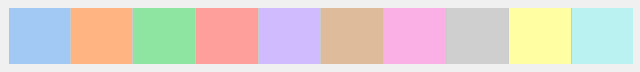

In [2]:
sns.palplot(sns.color_palette('pastel'))

## EDA

In [3]:
# Load data
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')

In [4]:
print('The shape of the training dataset is %s' % (train.shape,))
print('There are %d missing values in the excerpt column' % train.excerpt.isna().sum())
print('There are %d missing values in the target column' % train.target.isna().sum())
train.head()

The shape of the training dataset is (2834, 6)
There are 0 missing values in the excerpt column
There are 0 missing values in the target column


,id,url_legal,license,excerpt,target,standard_error
0,c12129c31,NaN,NaN,When the young people returned to the ballroom...,-0.340259,0.464009
1,85aa80a4c,NaN,NaN,"All through dinner time, Mrs. Fayre was somewh...",-0.315372,0.480805
2,b69ac6792,NaN,NaN,"As Roger had predicted, the snow departed as q...",-0.580118,0.476676
3,dd1000b26,NaN,NaN,And outside before the palace a great garden w...,-1.054013,0.450007
4,37c1b32fb,NaN,NaN,Once upon a time there were Three Bears who li...,0.247197,0.510845


In [5]:
print(test.shape)
test.head()

(7, 4)


,id,url_legal,license,excerpt
0,c0f722661,NaN,NaN,My hope lay in Jack's promise that he would ke...
1,f0953f0a5,NaN,NaN,Dotty continued to go to Mrs. Gray's every nig...
2,0df072751,NaN,NaN,It was a bright and cheerful scene that greete...
3,04caf4e0c,https://en.wikipedia.org/wiki/Cell_division,CC BY-SA 3.0,Cell division is the process by which a parent...
4,0e63f8bea,https://en.wikipedia.org/wiki/Debugging,CC BY-SA 3.0,Debugging is the process of finding and resolv...


In [6]:
target_min = train.target.min()
target_max = train.target.max()
print('The minimum value in the target column is %f' % target_min)
print('The maximum value in the target column is %f' % target_max)

The minimum value in the target column is -3.676268
The maximum value in the target column is 1.711390


In [7]:
easy_hard = train[(train.target == target_min )| (train.target == target_max)].reset_index(drop=True)
print('The hardest passage corresponds to the target value %f. The passage is below:\n %s' % (target_min, easy_hard.excerpt[0]))
print('\nThe easy passage corresponds to the target value %f. The passage is below:\n %s' % (target_max, easy_hard.excerpt[1]))

The hardest passage corresponds to the target value -3.676268. The passage is below:
 The commutator is peculiar, consisting of only three segments of a copper ring, while in the simplest of other continuous current generators several times that number exist, and frequently 120! segments are to be found. These three segments are made so as to be removable in a moment for cleaning or replacement. They are mounted upon a metal support, and are surrounded on all sides by a free air space, and cannot, therefore, lose their insulated condition. This feature of air insulation is peculiar to this system, and is very important as a factor in the durability of the commutator. Besides this, the commutator is sustained by supports carried in flanges upon the shaft, which flanges, as an additional safeguard, are coated all over with hard rubber, one of the finest known insulators. It may be stated, without fear of contradiction, that no other commutator made is so thoroughly insulated and protecte

In [8]:
def target_sample(n, data = train):
    """
    Examine n samples from the train dataset.
    For convenience, do not take n greater than 5.
    """
    for i in range(n):
        sample = randint(0, len(data))
        print('Sample: ' + str(sample) + "\n" +\
              'Target: ' + str(data.iloc[sample]["target"]) + '\n' +\
              'Text: ' + data.iloc[sample]["excerpt"] + '\n\n'
             )
# Look at samples from training dataset
target_sample(3)

Sample: 930
Target: -1.120484394
Text: Vusi looked at the photograph and quickly answered, "Heptagon has seven sides!" Khosi added, "Yes, remember our teacher told us that Hepta means 'seven'." "Oh my wife, can you see how clever our children are? Okay, what about Deca, what does it mean?" questioned Dad. "Ten! Ten!" shouted Vusi and Khosi together. "Yes, that's why one of your cousins is called Decagon, but he is not coming because he has to represent the swimming team. There are so few Decagons at their school," Mom told them. Then the children asked, "Mom and Dad, can we invite our friend Circle from next door?" Their parents agreed that Circle was welcome to join the family gathering. Just then they heard a knock at the front door, and Dad got up to check. "The Quadrilaterals are here! Welcome! Welcome" called Dad. The rest of the family jump up to greet Square, Rectangle and the three Rhombus children. The Quadrilaterals are happy to arrive first.


Sample: 1074
Target: 0.17873449

In [9]:
se_min = train.standard_error.min()
se_max = train.standard_error.max()
print('The minimum value in the standard error column is %f' % se_min)
print('The maximum value in the standard error column is %f' % se_max)

The minimum value in the standard error column is 0.000000
The maximum value in the standard error column is 0.649671


In [10]:
agree_disagree = train[(train.standard_error == se_min )| (train.standard_error == se_max)].reset_index(drop=True)
print('The passage corresponds to the standard error value of %f. This suggests all readers agreed on the difficulty level. The passage is below:\n %s' % (se_min, agree_disagree.excerpt[0]))
print('\nThe passage corresponds to the standard error value of %f. This suggests readers disagreed the most on the difficulty level of this passage compared to the others. The passage is below:\n %s' % (se_max, agree_disagree.excerpt[1]))

The passage corresponds to the standard error value of 0.000000. This suggests all readers agreed on the difficulty level. The passage is below:
 The sun was shining in a cloudless sky, and no shadows lay on the mountain, and all day long they watched and waited, and at last, when the birds were singing their farewell song to the evening star, the children saw the shadows marching from the glen, trooping up the mountain side and dimming the purple of the heather.
And when the mountain top gleamed like a golden spear, they fixed their eyes on the line between the shadow and the sunshine.
"Now," said Connla, "the time has come."
"Oh, look! look!" said Nora, and as she spoke, just above the line of shadow a door opened out, and through its portals came a little piper dressed in green and gold. He stepped down, followed by another and another, until they were nine in all, and then the door slung back again.

The passage corresponds to the standard error value of 0.649671. This suggests rea

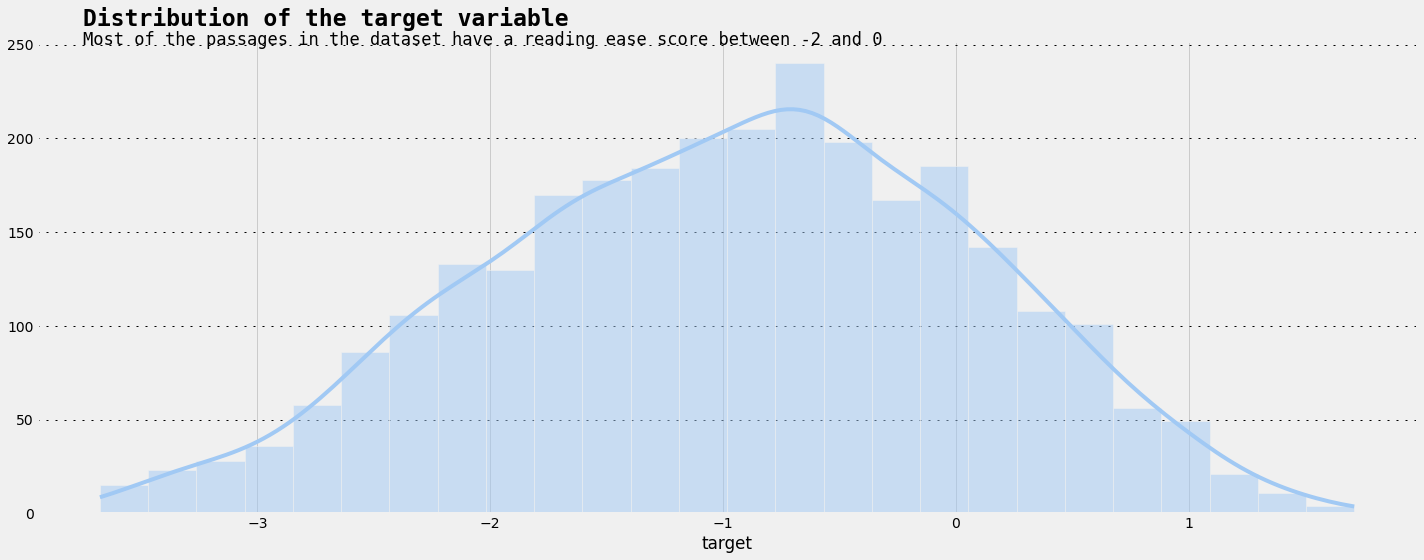

In [11]:
# Distribution plot of the target variable
fig, ax = plt.subplots(figsize=(20,8))
sns.histplot(train.target, kde = True)
ax.set_ylabel('')
ax.grid(which='both', axis='y', zorder=0, color='black', linestyle=':', dashes=(2,7))
ax.text(-3.75,260,'Distribution of the target variable',fontsize=23,fontweight='bold', fontfamily='monospace')
ax.text(-3.75,250,'Most of the passages in the dataset have a reading ease score between -2 and 0',fontsize=17,fontweight='light', fontfamily='monospace')

plt.tight_layout()
plt.savefig('target_dist.png')

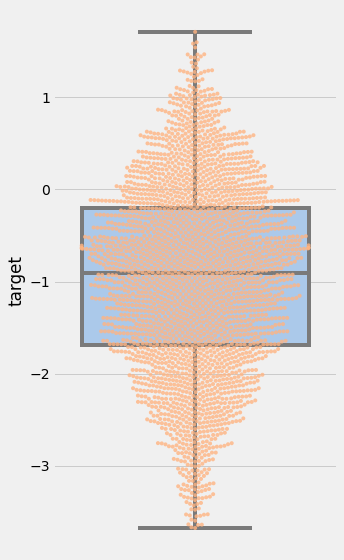

In [12]:
fig, ax = plt.subplots(figsize=(5, 8))
ax = sns.boxplot(y = 'target', data = train)
ax = sns.swarmplot(y = 'target', data = train, size = 4, color = sns.color_palette('pastel')[1], alpha = .8)


plt.tight_layout()

plt.savefig('target_box.png')

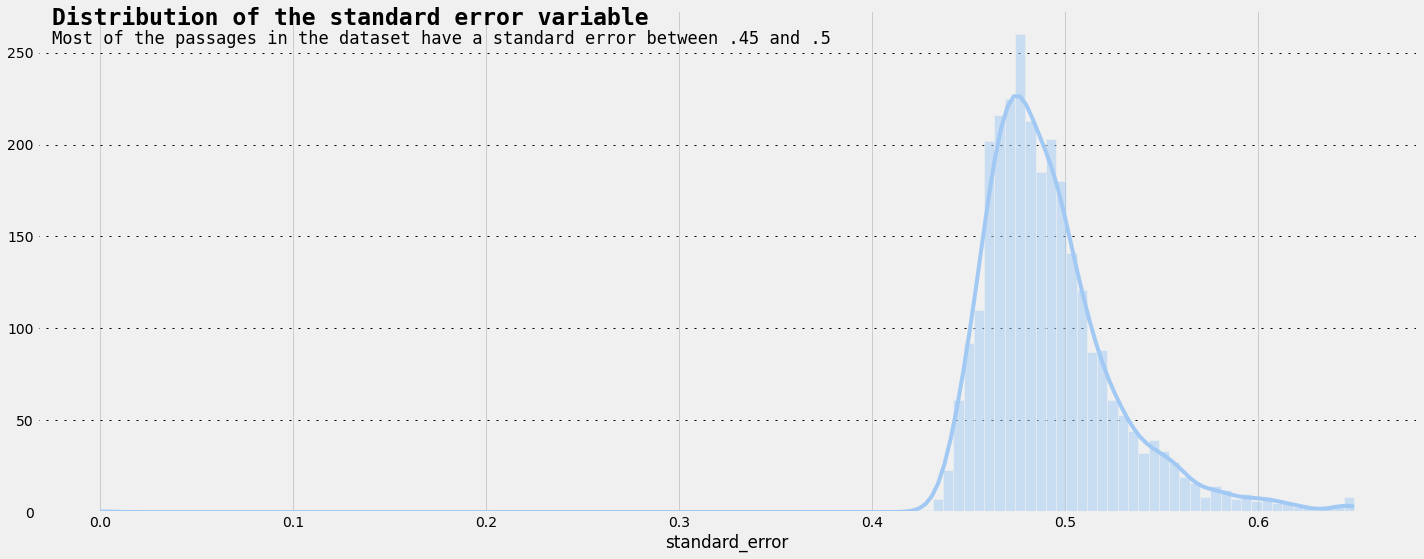

In [13]:
fig, ax = plt.subplots(figsize=(20,8))
sns.histplot(train.standard_error, kde = True)
ax.set_ylabel('')
ax.grid(which='both', axis='y', zorder=0, color='black', linestyle=':', dashes=(2,7))
ax.text(-0.025,265,'Distribution of the standard error variable',fontsize=23,fontweight='bold', fontfamily='monospace')
ax.text(-0.025,255,'Most of the passages in the dataset have a standard error between .45 and .5',fontsize=17,fontweight='light', fontfamily='monospace')

plt.tight_layout()
plt.savefig('se_dist.png')

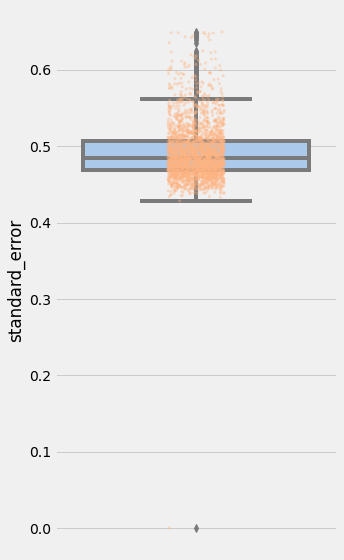

In [14]:
fig, ax = plt.subplots(figsize=(5, 8))
ax = sns.boxplot(y = 'standard_error', data = train)
ax = sns.stripplot(y = 'standard_error', data = train, size = 3, color = sns.color_palette('pastel')[1], alpha = .4)


plt.tight_layout()
plt.savefig('se_box.png')

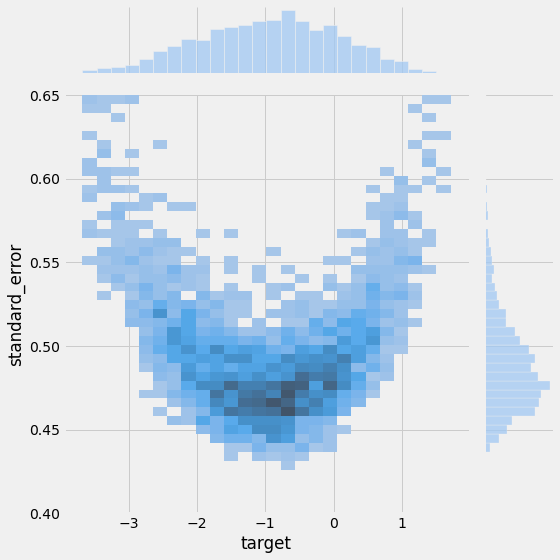

In [15]:
ax = sns.jointplot(x = 'target', y = 'standard_error', kind = 'hist', data = train, height = 8)
plt.ylim(.4, .65)
plt.tight_layout()
plt.savefig('jointplot.png')

In [16]:
train['excerpt_char_count'] = train['excerpt'].apply(
    lambda x : len(x)
)
train['excerpt_word_count'] = train['excerpt'].apply(
    lambda x : len(x.split(' '))
)

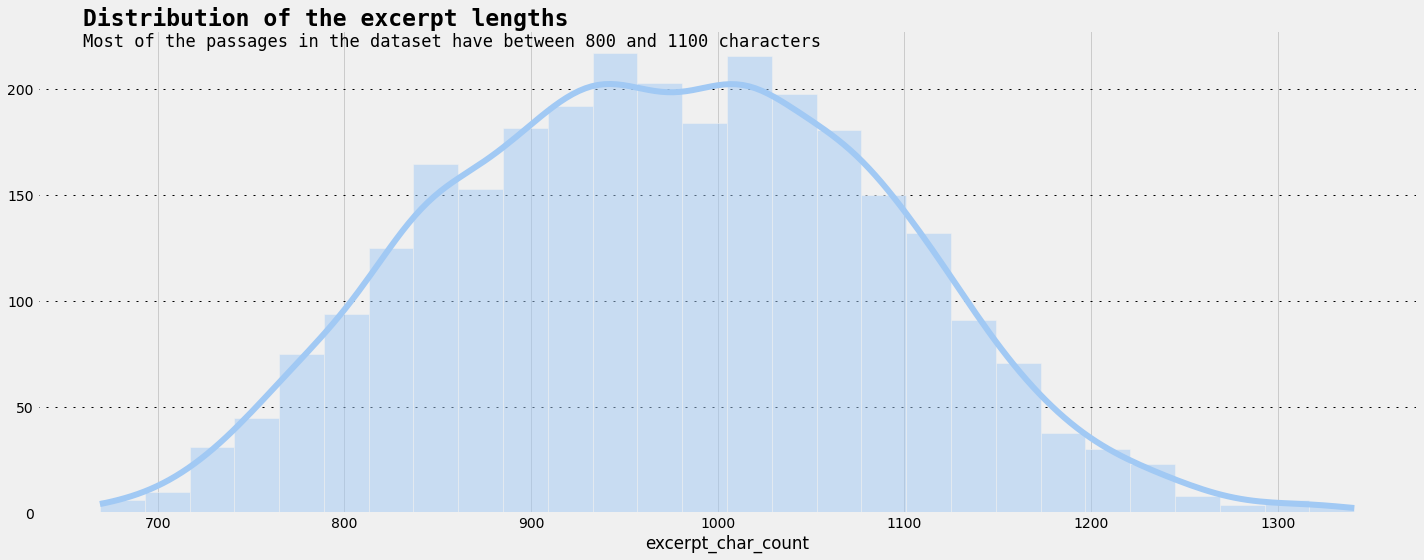

In [17]:
fig, ax = plt.subplots(figsize=(20,8))
sns.histplot(train.excerpt_char_count, kde = True, line_kws = {'linewidth':6})
ax.set_ylabel('')
ax.grid(which='both', axis='y', zorder=0, color='black', linestyle=':', dashes=(2,7))
ax.text(660,230,'Distribution of the excerpt lengths',fontsize=23,fontweight='bold', fontfamily='monospace')
ax.text(660,220,'Most of the passages in the dataset have between 800 and 1100 characters',fontsize=17,fontweight='light', fontfamily='monospace')

plt.tight_layout()
plt.savefig('excerpt_len.png')

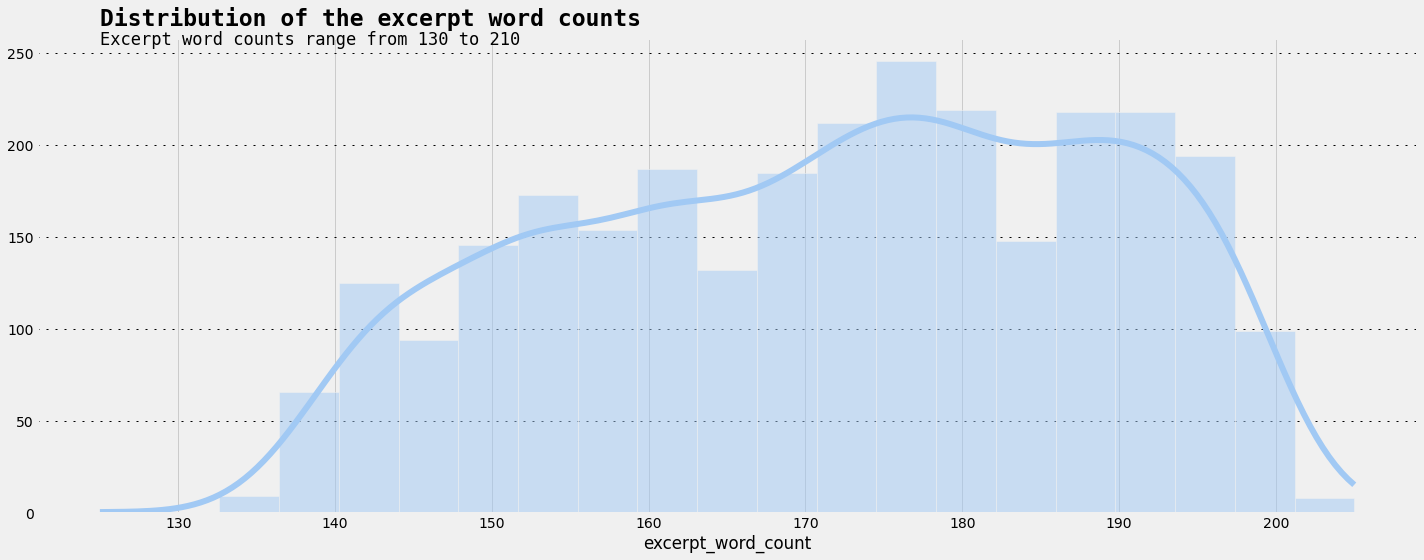

In [18]:
fig, ax = plt.subplots(figsize=(20,8))
sns.histplot(train.excerpt_word_count, kde = True, line_kws = {'linewidth':6})
ax.set_ylabel('')
ax.grid(which='both', axis='y', zorder=0, color='black', linestyle=':', dashes=(2,7))
ax.text(125,265,'Distribution of the excerpt word counts',fontsize=23,fontweight='bold', fontfamily='monospace')
ax.text(125,255,'Excerpt word counts range from 130 to 210',fontsize=17,fontweight='light', fontfamily='monospace')

plt.tight_layout()
plt.savefig('word_count.png')

In [19]:
# from wordcloud import WordCloud

# corpus = list(train['excerpt'].values)
# clean_named = (' '.join(str(w) for w in corpus))
# type(clean_named)

# wordcloud = WordCloud(width = 1200, height = 600,
#                 background_color ='white',
#                 min_font_size = 10).generate(clean_named)

# # plot the WordCloud image                       
# plt.figure(figsize = (8, 8), facecolor = None)
# plt.imshow(wordcloud)
# plt.axis("off")
# plt.tight_layout(pad = 0)
# plt.savefig("wordcloud.png")
# plt.show()

## Data Cleaning

In [20]:
# nlpretext functions to clean text
preprocessor = Preprocessor()
preprocessor.pipe(unpack_english_contractions)
preprocessor.pipe(remove_eol_characters)
preprocessor.pipe(lower_text)
preprocessor.pipe(remove_punct)
preprocessor.pipe(normalize_whitespace)

In [21]:
# custom function to remove stopwords using nltk dictionary
def no_stopwords(passage):
    passage = ' '.join(word for word in passage.split(' ') if word not in stop_words)
    return passage

In [22]:
# custom function to stem words using nltk.SnowballStemmer
stemmer = nltk.SnowballStemmer("english")

def nltk_stem(passage):
    passage = ' '.join(stemmer.stem(word) for word in passage.split(' '))
    return passage

In [23]:
# apply all the steps above in one function
def preprocess_data(passage):
    passage = passage.apply(preprocessor.run)
    passage = passage.apply(no_stopwords)
    passage = passage.apply(nltk_stem)
    
    return passage

In [24]:
train['clean_text'] = preprocess_data(train['excerpt'])
print('Text before cleaning: \n' + train['excerpt'][0] + '\n')
print('Text after cleaning: \n' + train['clean_text'][0])

Text before cleaning: 
When the young people returned to the ballroom, it presented a decidedly changed appearance. Instead of an interior scene, it was a winter landscape.
The floor was covered with snow-white canvas, not laid on smoothly, but rumpled over bumps and hillocks, like a real snow field. The numerous palms and evergreens that had decorated the room, were powdered with flour and strewn with tufts of cotton, like snow. Also diamond dust had been lightly sprinkled on them, and glittering crystal icicles hung from the branches.
At each end of the room, on the wall, hung a beautiful bear-skin rug.
These rugs were for prizes, one for the girls and one for the boys. And this was the game.
The girls were gathered at one end of the room and the boys at the other, and one end was called the North Pole, and the other the South Pole. Each player was given a small flag which they were to plant on reaching the Pole.
This would have been an easy matter, but each traveller was obliged to 

## Linear Models

In [25]:
# partition the target variable into 10 discrete intervals
train['target_bin'] = pd.cut(train.target, 10, labels=[i for i in range(10)])

# placeholder column to be filled by for loop
train['k_fold'] = 0

# Generate the train/test indices to split the data
skf = StratifiedKFold(n_splits=10, random_state=32, shuffle=True)
gen_fold = skf.split(train.id, y=train.target_bin)

# Assign k-fold for train and test
for k_fold, (train_index, val_index) in enumerate(gen_fold):
    train.loc[val_index, 'k_fold'] = k_fold

train['k_fold'] = train['k_fold'].astype('int8')

In [26]:
train.head()

,id,url_legal,license,excerpt,target,standard_error,excerpt_char_count,excerpt_word_count,clean_text,target_bin,k_fold
0,c12129c31,NaN,NaN,When the young people returned to the ballroom...,-0.340259,0.464009,992,174,young peopl return ballroom present decid chan...,6,8
1,85aa80a4c,NaN,NaN,"All through dinner time, Mrs. Fayre was somewh...",-0.315372,0.480805,937,164,dinner time mrs fayr somewhat silent eye rest ...,6,2
2,b69ac6792,NaN,NaN,"As Roger had predicted, the snow departed as q...",-0.580118,0.476676,908,162,roger predict snow depart quick came two day s...,5,7
3,dd1000b26,NaN,NaN,And outside before the palace a great garden w...,-1.054013,0.450007,909,163,outsid palac great garden wall round fill full...,4,9
4,37c1b32fb,NaN,NaN,Once upon a time there were Three Bears who li...,0.247197,0.510845,723,147,upon time three bear live togeth hous wood one...,7,7


In [27]:
t = train[train["k_fold"]!=0].reset_index(drop=True)
v = train[train["k_fold"]==0].reset_index(drop=True)

t_excerpt, t_score = t['excerpt'].values, t['target'].values
v_excerpt, v_score = v['excerpt'].values, v['target'].values

t_clean, t_score = t['clean_text'].values, t['target'].values
v_clean, v_score = v['clean_text'].values, v['target'].values

In [28]:
print(t_excerpt.shape, v_excerpt.shape)
print(t_score.shape, v_score.shape)

(2550,) (284,)
(2550,) (284,)


### All Text

#### Ridge

In [29]:
# Model to use 
ridge_base = Ridge(fit_intercept=True)

# Create pipeline to go through steps 
ridge_pipeline = make_pipeline(
    TfidfVectorizer(binary=True, ngram_range=(1, 1)),
    ridge_base
)

# Train model
ridge_pipeline.fit(t_excerpt, t_score)

# Predict and calculate MSE
pred = ridge_pipeline.predict(v_excerpt)
rmse = mean_squared_error(v_score, pred, squared=False)

print("RMSE Loss using Ridge and TfIdfVectorizer: %0.5f" % rmse)

RMSE Loss using Ridge and TfIdfVectorizer: 0.73107


/Users/quilviohernandez/Desktop/education/data-sci/text-complexity/text_complexity_venv/lib/python3.9/site-packages/sklearn/linear_model/_base.py:148: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2. Please leave the normalize parameter to its default value to silence this warning. The default behavior of this estimator is to not do any normalization. If normalization is needed please use sklearn.preprocessing.StandardScaler instead.
  warnings.warn(


#### Linear

In [30]:
# Model to use 
linear_base = LinearRegression(fit_intercept=True)

# Create pipeline to go through steps 
linear_pipeline = make_pipeline(
    TfidfVectorizer(binary=True, ngram_range=(1, 1)),
    linear_base
)

# Train model
linear_pipeline.fit(t_excerpt, t_score)

# Predict and calculate MSE
pred = linear_pipeline.predict(v_excerpt)
rmse = mean_squared_error(v_score, pred, squared=False)

print("RMSE Loss using LinearRegression and TfIdfVectorizer: %0.5f" % rmse)

RMSE Loss using LinearRegression and TfIdfVectorizer: 0.76888


/Users/quilviohernandez/Desktop/education/data-sci/text-complexity/text_complexity_venv/lib/python3.9/site-packages/sklearn/linear_model/_base.py:148: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2. Please leave the normalize parameter to its default value to silence this warning. The default behavior of this estimator is to not do any normalization. If normalization is needed please use sklearn.preprocessing.StandardScaler instead.
  warnings.warn(


#### Lasso

In [31]:
# Model to use 
lasso_base = Lasso(fit_intercept=True)

# Create pipeline to go through steps 
lasso_pipeline = make_pipeline(
    TfidfVectorizer(binary=True, ngram_range=(1, 1)),
    lasso_base
)

# Train model
lasso_pipeline.fit(t_excerpt, t_score)

# Predict and calculate MSE
pred = lasso_pipeline.predict(v_excerpt)
rmse = mean_squared_error(v_score, pred, squared=False)

print("RMSE Loss using Lasso and TfIdfVectorizer: %0.5f" % rmse)

RMSE Loss using Lasso and TfIdfVectorizer: 1.03147


/Users/quilviohernandez/Desktop/education/data-sci/text-complexity/text_complexity_venv/lib/python3.9/site-packages/sklearn/linear_model/_base.py:148: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2. Please leave the normalize parameter to its default value to silence this warning. The default behavior of this estimator is to not do any normalization. If normalization is needed please use sklearn.preprocessing.StandardScaler instead.
  warnings.warn(


#### ElasticNet

In [32]:
# Model to use 
elastic_base = ElasticNet(fit_intercept=True)

# Create pipeline to go through steps 
elastic_pipeline = make_pipeline(
    TfidfVectorizer(binary=True, ngram_range=(1, 1)),
    elastic_base
)

# Train model
elastic_pipeline.fit(t_excerpt, t_score)

# Predict and calculate MSE
pred = elastic_pipeline.predict(v_excerpt)
rmse = mean_squared_error(v_score, pred, squared=False)

print("RMSE Loss using ElasticNet and TfIdfVectorizer: %0.5f" % rmse)

RMSE Loss using ElasticNet and TfIdfVectorizer: 1.03147


/Users/quilviohernandez/Desktop/education/data-sci/text-complexity/text_complexity_venv/lib/python3.9/site-packages/sklearn/linear_model/_base.py:148: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2. Please leave the normalize parameter to its default value to silence this warning. The default behavior of this estimator is to not do any normalization. If normalization is needed please use sklearn.preprocessing.StandardScaler instead.
  warnings.warn(


Elastic and Lasso perform poorly. Ignore them going forward.

Train models with cleaned data

### Clean data

In [33]:
# Model to use 
ridge_base = Ridge(fit_intercept=True)

# Create pipeline to go through steps 
ridge_pipeline = make_pipeline(
    TfidfVectorizer(binary=True, ngram_range=(1, 1)),
    ridge_base
)

# Train model
ridge_pipeline.fit(t_clean, t_score)

# Predict and calculate MSE
pred = ridge_pipeline.predict(v_clean)
rmse = mean_squared_error(v_score, pred, squared=False)

print("RMSE Loss using Ridge and TfIdfVectorizer: %0.5f" % rmse)

RMSE Loss using Ridge and TfIdfVectorizer: 0.71092


/Users/quilviohernandez/Desktop/education/data-sci/text-complexity/text_complexity_venv/lib/python3.9/site-packages/sklearn/linear_model/_base.py:148: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2. Please leave the normalize parameter to its default value to silence this warning. The default behavior of this estimator is to not do any normalization. If normalization is needed please use sklearn.preprocessing.StandardScaler instead.
  warnings.warn(


In [34]:
# Model to use 
linear_base = LinearRegression(fit_intercept=True)

# Create pipeline to go through steps 
linear_pipeline = make_pipeline(
    TfidfVectorizer(binary=True, ngram_range=(1, 1)),
    linear_base
)

# Train model
linear_pipeline.fit(t_clean, t_score)

# Predict and calculate MSE
pred = linear_pipeline.predict(v_clean)
rmse = mean_squared_error(v_score, pred, squared=False)

print("RMSE Loss using LinearRegression and TfIdfVectorizer: %0.5f" % rmse)

RMSE Loss using LinearRegression and TfIdfVectorizer: 0.78198


/Users/quilviohernandez/Desktop/education/data-sci/text-complexity/text_complexity_venv/lib/python3.9/site-packages/sklearn/linear_model/_base.py:148: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2. Please leave the normalize parameter to its default value to silence this warning. The default behavior of this estimator is to not do any normalization. If normalization is needed please use sklearn.preprocessing.StandardScaler instead.
  warnings.warn(


Minimal improvement for ridge. Worse for Linear

### Grid Search for Ridge

Previous ran for Tfidf as well and found nothing better than parameters we've been using (default).

'tfidfvectorizer__lowercase': [True, False],
'tfidfvectorizer__stop_words': ['english', None],
'tfidfvectorizer__ngram_range': [(1, 1), (1, 2), (2, 2)],
'tfidfvectorizer__norm': ['l1', 'l2']
{'ridge__alpha': 0.01, 'ridge__max_iter': 1000, 'tfidfvectorizer__lowercase': False, 'tfidfvectorizer__ngram_range': (1, 1), 'tfidfvectorizer__norm': 'l1', 'tfidfvectorizer__stop_words': None}

In [35]:
ridge_optim = Ridge(fit_intercept=True)
ridge_params = [{
    'ridge__alpha': [.000001, .00001, .0001, .001, .005, .01, .05, .1, .5, 1, 10],
    'ridge__max_iter': [1000,100000]}]
ridge_pipeline = make_pipeline(
    TfidfVectorizer(binary=True, lowercase=False, ngram_range = (1,1), norm = 'l1', stop_words = None),
    ridge_optim
)

# Train model
search = GridSearchCV(ridge_pipeline, ridge_params, n_jobs=-1)
search.fit(t_clean, t_score)

# Evaluate the performance on validation set
pred = search.predict(v_clean)
rmse = mean_squared_error(v_score, pred, squared=False)

print("RMSE Loss using Ridge and TfIdfVectorizer: %0.5f" % rmse)
print(search.best_params_)

/Users/quilviohernandez/Desktop/education/data-sci/text-complexity/text_complexity_venv/lib/python3.9/site-packages/sklearn/linear_model/_base.py:148: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2. Please leave the normalize parameter to its default value to silence this warning. The default behavior of this estimator is to not do any normalization. If normalization is needed please use sklearn.preprocessing.StandardScaler instead.
  warnings.warn(
/Users/quilviohernandez/Desktop/education/data-sci/text-complexity/text_complexity_venv/lib/python3.9/site-packages/sklearn/linear_model/_base.py:148: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2. Please leave the normalize parameter to its default value to silence this warning. The default behavior of this estimator is to not do any normalization. If normalization is needed please use sklearn.preprocessing.StandardScaler instead.
  warnings.warn(
/Users/quilviohern

/Users/quilviohernandez/Desktop/education/data-sci/text-complexity/text_complexity_venv/lib/python3.9/site-packages/sklearn/linear_model/_base.py:148: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2. Please leave the normalize parameter to its default value to silence this warning. The default behavior of this estimator is to not do any normalization. If normalization is needed please use sklearn.preprocessing.StandardScaler instead.
  warnings.warn(
/Users/quilviohernandez/Desktop/education/data-sci/text-complexity/text_complexity_venv/lib/python3.9/site-packages/sklearn/linear_model/_base.py:148: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2. Please leave the normalize parameter to its default value to silence this warning. The default behavior of this estimator is to not do any normalization. If normalization is needed please use sklearn.preprocessing.StandardScaler instead.
  warnings.warn(
/Users/quilviohern

/Users/quilviohernandez/Desktop/education/data-sci/text-complexity/text_complexity_venv/lib/python3.9/site-packages/sklearn/linear_model/_base.py:148: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2. Please leave the normalize parameter to its default value to silence this warning. The default behavior of this estimator is to not do any normalization. If normalization is needed please use sklearn.preprocessing.StandardScaler instead.
  warnings.warn(
/Users/quilviohernandez/Desktop/education/data-sci/text-complexity/text_complexity_venv/lib/python3.9/site-packages/sklearn/linear_model/_base.py:148: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2. Please leave the normalize parameter to its default value to silence this warning. The default behavior of this estimator is to not do any normalization. If normalization is needed please use sklearn.preprocessing.StandardScaler instead.
  warnings.warn(
/Users/quilviohern

/Users/quilviohernandez/Desktop/education/data-sci/text-complexity/text_complexity_venv/lib/python3.9/site-packages/sklearn/linear_model/_base.py:148: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2. Please leave the normalize parameter to its default value to silence this warning. The default behavior of this estimator is to not do any normalization. If normalization is needed please use sklearn.preprocessing.StandardScaler instead.
  warnings.warn(
/Users/quilviohernandez/Desktop/education/data-sci/text-complexity/text_complexity_venv/lib/python3.9/site-packages/sklearn/linear_model/_base.py:148: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2. Please leave the normalize parameter to its default value to silence this warning. The default behavior of this estimator is to not do any normalization. If normalization is needed please use sklearn.preprocessing.StandardScaler instead.
  warnings.warn(
/Users/quilviohern

/Users/quilviohernandez/Desktop/education/data-sci/text-complexity/text_complexity_venv/lib/python3.9/site-packages/sklearn/linear_model/_base.py:148: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2. Please leave the normalize parameter to its default value to silence this warning. The default behavior of this estimator is to not do any normalization. If normalization is needed please use sklearn.preprocessing.StandardScaler instead.
  warnings.warn(
/Users/quilviohernandez/Desktop/education/data-sci/text-complexity/text_complexity_venv/lib/python3.9/site-packages/sklearn/linear_model/_base.py:148: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2. Please leave the normalize parameter to its default value to silence this warning. The default behavior of this estimator is to not do any normalization. If normalization is needed please use sklearn.preprocessing.StandardScaler instead.
  warnings.warn(
/Users/quilviohern

/Users/quilviohernandez/Desktop/education/data-sci/text-complexity/text_complexity_venv/lib/python3.9/site-packages/sklearn/linear_model/_base.py:148: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2. Please leave the normalize parameter to its default value to silence this warning. The default behavior of this estimator is to not do any normalization. If normalization is needed please use sklearn.preprocessing.StandardScaler instead.
  warnings.warn(
/Users/quilviohernandez/Desktop/education/data-sci/text-complexity/text_complexity_venv/lib/python3.9/site-packages/sklearn/linear_model/_base.py:148: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2. Please leave the normalize parameter to its default value to silence this warning. The default behavior of this estimator is to not do any normalization. If normalization is needed please use sklearn.preprocessing.StandardScaler instead.
  warnings.warn(
/Users/quilviohern

RMSE Loss using Ridge and TfIdfVectorizer: 0.71234
{'ridge__alpha': 0.01, 'ridge__max_iter': 1000}


/Users/quilviohernandez/Desktop/education/data-sci/text-complexity/text_complexity_venv/lib/python3.9/site-packages/sklearn/linear_model/_base.py:148: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2. Please leave the normalize parameter to its default value to silence this warning. The default behavior of this estimator is to not do any normalization. If normalization is needed please use sklearn.preprocessing.StandardScaler instead.
  warnings.warn(


### Count Vectorizer

In [36]:
ridge_best = Ridge(alpha = .01, fit_intercept=True, max_iter = 1000)
ridge_pipeline = make_pipeline(
    CountVectorizer(binary=True, lowercase=False, ngram_range = (1,1), stop_words = None),
    ridge_best
)

# Train model
ridge_pipeline.fit(t_clean, t_score)

# Predict and calculate MSE
pred = ridge_pipeline.predict(v_clean)
rmse = mean_squared_error(v_score, pred, squared=False)

print("RMSE Loss using Ridge and CountVectorizer: %0.5f" % rmse)

RMSE Loss using Ridge and CountVectorizer: 0.84287


/Users/quilviohernandez/Desktop/education/data-sci/text-complexity/text_complexity_venv/lib/python3.9/site-packages/sklearn/linear_model/_base.py:148: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2. Please leave the normalize parameter to its default value to silence this warning. The default behavior of this estimator is to not do any normalization. If normalization is needed please use sklearn.preprocessing.StandardScaler instead.
  warnings.warn(


### Best

In [37]:
ridge_best = Ridge(alpha = .01, fit_intercept=True, max_iter = 1000)
ridge_pipeline = make_pipeline(
    TfidfVectorizer(binary=True, lowercase=False, ngram_range = (1,1), norm = 'l1', stop_words = None),
    ridge_best
)

# Train model
ridge_pipeline.fit(t_clean, t_score)

# Predict and calculate MSE
pred = ridge_pipeline.predict(v_clean)
rmse = mean_squared_error(v_score, pred, squared=False)

print("RMSE Loss using Ridge and TfidfVectorizer: %0.5f" % rmse)

RMSE Loss using Ridge and TfidfVectorizer: 0.71234


/Users/quilviohernandez/Desktop/education/data-sci/text-complexity/text_complexity_venv/lib/python3.9/site-packages/sklearn/linear_model/_base.py:148: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2. Please leave the normalize parameter to its default value to silence this warning. The default behavior of this estimator is to not do any normalization. If normalization is needed please use sklearn.preprocessing.StandardScaler instead.
  warnings.warn(


## Word Embedding Models

### Callbacks and Helper functions

In [38]:
# Reduce learning rate when a metric has stopped improving. 
learning_rate_reduction = ReduceLROnPlateau(monitor='val_root_mean_squared_error', 
                                            patience=5, 
                                            verbose=1, 
                                            factor=0.1, 
                                            min_lr=0.00001)

# Stop training when a monitored metric has stopped improving.
early_stopping = EarlyStopping(
    min_delta=0.001, # minimium amount of change to count as an improvement
    patience=5, # how many epochs to wait before stopping
    restore_best_weights=True,
)

In [39]:
# Output helper function from https://www.kaggle.com/donmarch14/commonlit-detailed-guide-to-learn-nlp
def predict_complexity(model, excerpt):
    # Create the sequences
    padding_type='post'
    sample_sequences = tokenizer.texts_to_sequences(excerpt)
    excerpt_padded = pad_sequences(sample_sequences, padding=padding_type, 
                                 maxlen=maxlen) 
    classes = model.predict(excerpt_padded)
    for x in range(len(excerpt_padded)):
        print(excerpt[x])
        print(classes[x])
        print('\n')

In [40]:
# Helper plotting function from https://www.kaggle.com/donmarch14/commonlit-detailed-guide-to-learn-nlp
def plot_graphs(history, string, model):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.title(model)
    plt.legend([string, 'val_'+string])
    savefig = model + '_' + string + '.png'
    plt.tight_layout()
    plt.savefig(savefig)
    plt.show()

### Set Parameters

In [41]:
corpus = train.clean_text

In [42]:
# Get dictionary size
dictionary = Counter()
train['clean_text'].str.split().apply(dictionary.update)
print(len(dictionary.keys()))

17233


In [43]:
# Set parameters
dict_size = 17233
dim_embed = 32
maxlen = 40
trunc = 'post'
pad = 'post'
tok = "<OOV>"

In [44]:
tokenizer = Tokenizer(num_words = dict_size, oov_token=tok)
tokenizer.fit_on_texts(corpus)
word_index = tokenizer.word_index

In [45]:
train_seq = tokenizer.texts_to_sequences(corpus)
train_pad = pad_sequences(train_seq,maxlen=maxlen, 
                                truncating=trunc, padding=pad)

train_labels = np.array(train.target)

In [46]:
print(train_pad.shape)
print(train_labels.shape)

(2834, 40)
(2834,)


### Simple Model

In [47]:
# The Sequential class builds a stack of layers
# Embedding layer is the input layer of our word embeddings
# GlobalAveragePooling1D layer is a pooling operation for 1D data that takes the global average
# Dense(n) layer is a densely-connected NN layer with output dimensionality of n
simple_model = tf.keras.Sequential([
    tf.keras.layers.Embedding(dict_size, dim_embed, input_length=maxlen),
    tf.keras.layers.GlobalAveragePooling1D(),  
    tf.keras.layers.Dense(1)
])

# compile method configures the model for training
# We are using RMSE as the evaluating metric
simple_model.compile(loss='mean_squared_error', metrics=[RootMeanSquaredError()])
simple_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 40, 32)            551456    
                                                                 
 global_average_pooling1d (G  (None, 32)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 551,489
Trainable params: 551,489
Non-trainable params: 0
_________________________________________________________________


2022-03-03 20:43:30.669258: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [48]:
# Train model using 50 epochs
history = simple_model.fit(train_pad, train_labels, 
                    epochs=50, validation_split=0.1,
                   callbacks=[early_stopping,learning_rate_reduction])

Epoch 1/50
80/80 [==============================] - 1s 11ms/step - loss: 1.6936 - root_mean_squared_error: 1.3014 - val_loss: 1.5567 - val_root_mean_squared_error: 1.2477 - lr: 0.0010
Epoch 2/50
80/80 [==============================] - 0s 4ms/step - loss: 1.2549 - root_mean_squared_error: 1.1202 - val_loss: 1.2359 - val_root_mean_squared_error: 1.1117 - lr: 0.0010
Epoch 3/50
80/80 [==============================] - 0s 3ms/step - loss: 0.9872 - root_mean_squared_error: 0.9936 - val_loss: 1.0535 - val_root_mean_squared_error: 1.0264 - lr: 0.0010
Epoch 4/50
80/80 [==============================] - 0s 3ms/step - loss: 0.8183 - root_mean_squared_error: 0.9046 - val_loss: 0.9214 - val_root_mean_squared_error: 0.9599 - lr: 0.0010
Epoch 5/50
80/80 [==============================] - 0s 3ms/step - loss: 0.6872 - root_mean_squared_error: 0.8290 - val_loss: 0.8283 - val_root_mean_squared_error: 0.9101 - lr: 0.0010
Epoch 6/50
80/80 [==============================] - 0s 3ms/step - loss: 0.5805 - roo

We can see from the difference in the RMSE on the train and test set the model is overfitting (0.4376 vs. 0.8697)

### Optimizing Model

In [49]:
# Embedding size should be the fourth root of the dictionary size
def fourth_root(num):
    return math.sqrt(math.sqrt(num))

fourth_root(17233)

11.457509394228683

In [50]:
dim_embed = 12

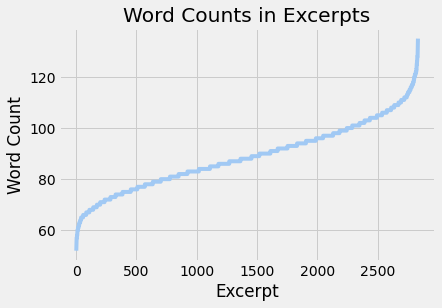

In [51]:
excerpt_num=[]
word_count=[]
counter=1
for item in corpus:
    excerpt_num.append(counter)
    counter=counter+1
    word_count.append(len(item.split(' ')))
sorted_count = sorted(word_count)
plt.xlabel('Excerpt')
plt.ylabel('Word Count')
plt.title('Word Counts in Excerpts')
plt.plot(excerpt_num,sorted_count)

plt.show()

In [52]:
maxlen = 130

In [53]:
train_pad = pad_sequences(train_seq,maxlen=maxlen, 
                                truncating=trunc, padding=pad)

train_labels = np.array(train.target)

In [54]:
print(train_pad.shape)
print(train_labels.shape)

(2834, 130)
(2834,)


In [55]:
"""
Same as above but now we're using 2 dense layers.
The first two layers are the same just with our updated parameters for optimization
The first Dense layer now has 32 units or nodes and uses ReLU as the activation function. 
We're also using L2 regularization as is common with NLP problems
"""
opt_model = tf.keras.Sequential([
    tf.keras.layers.Embedding(dict_size, dim_embed, input_length=maxlen),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(32, activation='relu', kernel_regularizer = tf.keras.regularizers.l2(0.01)),
    tf.keras.layers.Dense(1)
])
opt_model.compile(loss='mean_squared_error',optimizer='adam', metrics=[RootMeanSquaredError()])
opt_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 130, 12)           206796    
                                                                 
 global_average_pooling1d_1   (None, 12)               0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dense_1 (Dense)             (None, 32)                416       
                                                                 
 dense_2 (Dense)             (None, 1)                 33        
                                                                 
Total params: 207,245
Trainable params: 207,245
Non-trainable params: 0
_________________________________________________________________


In [56]:
history = opt_model.fit(train_pad, train_labels, 
                    epochs=100, validation_split=0.1,
                    callbacks=[early_stopping,learning_rate_reduction])

Epoch 1/100
80/80 [==============================] - 1s 4ms/step - loss: 1.7366 - root_mean_squared_error: 1.2687 - val_loss: 1.3852 - val_root_mean_squared_error: 1.1299 - lr: 0.0010
Epoch 2/100
80/80 [==============================] - 0s 3ms/step - loss: 1.1389 - root_mean_squared_error: 1.0216 - val_loss: 1.1872 - val_root_mean_squared_error: 1.0534 - lr: 0.0010
Epoch 3/100
80/80 [==============================] - 1s 7ms/step - loss: 0.9942 - root_mean_squared_error: 0.9603 - val_loss: 1.0352 - val_root_mean_squared_error: 0.9822 - lr: 0.0010
Epoch 4/100
80/80 [==============================] - 0s 4ms/step - loss: 0.7991 - root_mean_squared_error: 0.8450 - val_loss: 0.8292 - val_root_mean_squared_error: 0.8541 - lr: 0.0010
Epoch 5/100
80/80 [==============================] - 0s 3ms/step - loss: 0.6063 - root_mean_squared_error: 0.7073 - val_loss: 0.7370 - val_root_mean_squared_error: 0.7913 - lr: 0.0010
Epoch 6/100
80/80 [==============================] - 0s 4ms/step - loss: 0.4950 

My hope lay in Jack's promise that he would keep a bright light burning in the upper story to guide me on my course. On a clear night this light was visible from the village, but somehow or other I failed to take into account the state of the weather. The air was full of eddying flakes, which would render the headlight of a locomotive invisible a hundred yards distant. Strange that this important fact never occurred to me until I was fully a fourth of a mile from the village. Then, after looking in vain for the beacon light, the danger of my situation struck me, and I halted.
"I am certain to go wrong," I said to myself.
"It is out of my power to follow a direct course without something to serve as a compass. I will go back to the village and wait till morning."
[-0.8343119]


Dotty continued to go to Mrs. Gray's every night with the milk. Sometimes Katie went with her, and then they always paused a while under the acorn-tree and played "King and Queen." Dotty said she wished they coul

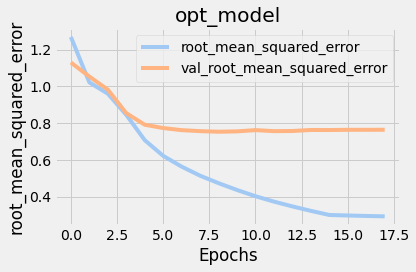

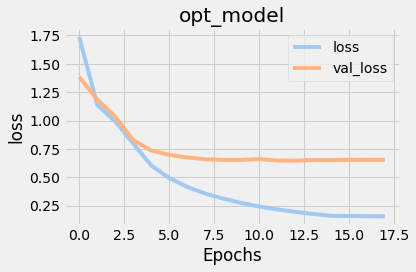

In [57]:
predict_complexity(opt_model, test['excerpt'])
plot_graphs(history, "root_mean_squared_error", 'opt_model')
plot_graphs(history, "loss", 'opt_model')
# model is still overfitting

### Convolutional Neural Network (CNN/ConvNet)

In [58]:
"""
Same as above but with an additional 1D convolution layer
"""
cnn_model = tf.keras.Sequential([
    tf.keras.layers.Embedding(dict_size, dim_embed, input_length=maxlen),
    tf.keras.layers.Conv1D(dim_embed, 5, activation='relu'),
    tf.keras.layers.GlobalMaxPooling1D(), 
    tf.keras.layers.Dense(32, activation='relu', kernel_regularizer = tf.keras.regularizers.l2(0.01)),
    tf.keras.layers.Dense(1)
])

# Default learning rate for the Adam optimizer is 0.001
# Let's slow down the learning rate by 10.
learning_rate = 0.0001
cnn_model.compile(loss='mean_squared_error',optimizer=tf.keras.optimizers.Adam(learning_rate), metrics=[RootMeanSquaredError()])
cnn_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 130, 12)           206796    
                                                                 
 conv1d (Conv1D)             (None, 126, 12)           732       
                                                                 
 global_max_pooling1d (Globa  (None, 12)               0         
 lMaxPooling1D)                                                  
                                                                 
 dense_3 (Dense)             (None, 32)                416       
                                                                 
 dense_4 (Dense)             (None, 1)                 33        
                                                                 
Total params: 207,977
Trainable params: 207,977
Non-trainable params: 0
________________________________________________

In [59]:
history = cnn_model.fit(train_pad, train_labels, 
                    epochs=100, validation_split=0.1,
                    callbacks=[early_stopping,learning_rate_reduction])

Epoch 1/100
80/80 [==============================] - 1s 6ms/step - loss: 2.1538 - root_mean_squared_error: 1.4037 - val_loss: 2.1177 - val_root_mean_squared_error: 1.3917 - lr: 1.0000e-04
Epoch 2/100
80/80 [==============================] - 1s 8ms/step - loss: 1.9328 - root_mean_squared_error: 1.3245 - val_loss: 1.9382 - val_root_mean_squared_error: 1.3274 - lr: 1.0000e-04
Epoch 3/100
80/80 [==============================] - 1s 9ms/step - loss: 1.7609 - root_mean_squared_error: 1.2597 - val_loss: 1.7862 - val_root_mean_squared_error: 1.2705 - lr: 1.0000e-04
Epoch 4/100
80/80 [==============================] - 1s 8ms/step - loss: 1.6000 - root_mean_squared_error: 1.1958 - val_loss: 1.6410 - val_root_mean_squared_error: 1.2136 - lr: 1.0000e-04
Epoch 5/100
80/80 [==============================] - 0s 6ms/step - loss: 1.4460 - root_mean_squared_error: 1.1313 - val_loss: 1.5101 - val_root_mean_squared_error: 1.1600 - lr: 1.0000e-04
Epoch 6/100
80/80 [==============================] - 0s 5ms/

80/80 [==============================] - 0s 5ms/step - loss: 0.1309 - root_mean_squared_error: 0.1584 - val_loss: 0.8524 - val_root_mean_squared_error: 0.8645 - lr: 1.0000e-04
Epoch 45/100
80/80 [==============================] - 0s 5ms/step - loss: 0.1260 - root_mean_squared_error: 0.1481 - val_loss: 0.8519 - val_root_mean_squared_error: 0.8653 - lr: 1.0000e-04
Epoch 46/100
80/80 [==============================] - 0s 4ms/step - loss: 0.1215 - root_mean_squared_error: 0.1383 - val_loss: 0.8494 - val_root_mean_squared_error: 0.8649 - lr: 1.0000e-04
Epoch 47/100
71/80 [=========================>....] - ETA: 0s - loss: 0.1170 - root_mean_squared_error: 0.1285
Epoch 47: ReduceLROnPlateau reducing learning rate to 1e-05.
80/80 [==============================] - 0s 5ms/step - loss: 0.1172 - root_mean_squared_error: 0.1295 - val_loss: 0.8483 - val_root_mean_squared_error: 0.8653 - lr: 1.0000e-04
Epoch 48/100
80/80 [==============================] - 0s 5ms/step - loss: 0.1141 - root_mean_squar

My hope lay in Jack's promise that he would keep a bright light burning in the upper story to guide me on my course. On a clear night this light was visible from the village, but somehow or other I failed to take into account the state of the weather. The air was full of eddying flakes, which would render the headlight of a locomotive invisible a hundred yards distant. Strange that this important fact never occurred to me until I was fully a fourth of a mile from the village. Then, after looking in vain for the beacon light, the danger of my situation struck me, and I halted.
"I am certain to go wrong," I said to myself.
"It is out of my power to follow a direct course without something to serve as a compass. I will go back to the village and wait till morning."
[-0.8053411]


Dotty continued to go to Mrs. Gray's every night with the milk. Sometimes Katie went with her, and then they always paused a while under the acorn-tree and played "King and Queen." Dotty said she wished they coul

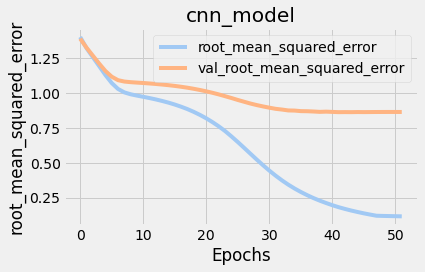

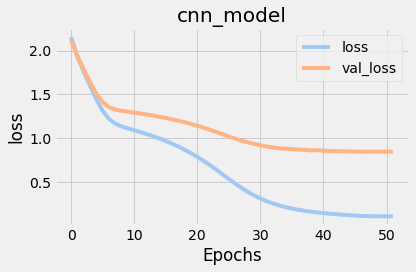

In [60]:
predict_complexity(cnn_model, test['excerpt'])
plot_graphs(history, "root_mean_squared_error", 'cnn_model')
plot_graphs(history, "loss", 'cnn_model')
# model is still overfitting

In [61]:
def build_model(hyper):
    model = keras.Sequential()
    model.add(tf.keras.layers.Embedding(dict_size, dim_embed, input_length=maxlen))

    # Find optimal number of units in dense layer between 16 and 256
    opt_units = hyper.Int('units', min_value=16, max_value=256, step=8)
    model.add(keras.layers.Dense(units=opt_units, activation='relu'))
    model.add(keras.layers.Dense(1))


    grid_lr = hyper.Choice('learning_rate', values=[1e-3, 1e-4])

    model.compile(optimizer=keras.optimizers.Adam(learning_rate=grid_lr),
                loss=keras.losses.MeanSquaredError(),
                metrics=[RootMeanSquaredError()])

    return model

In [62]:
tuner = kt.Hyperband(build_model,
                     max_epochs=10,
                     objective = kt.Objective("val_root_mean_squared_error", direction="min"),
                     factor=5,
                     directory='my_dir',
                     project_name='intro_to_kt')

In [63]:
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

In [64]:
tuner.search(train_pad, train_labels, epochs=5, validation_split=0.1, callbacks=[early_stop])

# Get the optimal hyperparameters
best_hyperparameters = tuner.get_best_hyperparameters(num_trials=1)[0]

Trial 13 Complete [00h 00m 07s]
val_root_mean_squared_error: 1.085249423980713

Best val_root_mean_squared_error So Far: 1.082438349723816
Total elapsed time: 00h 01m 05s
INFO:tensorflow:Oracle triggered exit


In [65]:
print(f"""Hyperband search complete. \nOptimal units of first dense layer: {best_hyperparameters.get('units')} \nOptimal learning rate: {best_hyperparameters.get('learning_rate')}.""")

Hyperband search complete. 
Optimal units of first dense layer: 208 
Optimal learning rate: 0.001.


In [66]:
"""
Model with best hyperparameters
"""
hyper_model = tf.keras.Sequential([
    tf.keras.layers.Embedding(dict_size, dim_embed, input_length=maxlen),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(160, activation='relu', kernel_regularizer = tf.keras.regularizers.l2(0.01)),
    tf.keras.layers.Dense(1)
])
hyper_model.compile(loss='mean_squared_error',optimizer='adam', metrics=[RootMeanSquaredError()])
hyper_model.summary()

learning_rate = 0.001
hyper_model.compile(loss='mean_squared_error',optimizer=tf.keras.optimizers.Adam(learning_rate), metrics=[RootMeanSquaredError()])
hyper_model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 130, 12)           206796    
                                                                 
 global_average_pooling1d (G  (None, 12)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dense_2 (Dense)             (None, 160)               2080      
                                                                 
 dense_3 (Dense)             (None, 1)                 161       
                                                                 
Total params: 209,037
Trainable params: 209,037
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_1"
_________________________________________________________________
 Layer (type)             

In [67]:
history = hyper_model.fit(train_pad, train_labels, 
                    epochs=100, validation_split=0.1,
                    callbacks=[early_stopping,learning_rate_reduction])

Epoch 1/100
80/80 [==============================] - 1s 4ms/step - loss: 1.4875 - root_mean_squared_error: 1.1627 - val_loss: 1.2500 - val_root_mean_squared_error: 1.0818 - lr: 0.0010
Epoch 2/100
80/80 [==============================] - 0s 3ms/step - loss: 1.0390 - root_mean_squared_error: 0.9921 - val_loss: 1.0552 - val_root_mean_squared_error: 1.0013 - lr: 0.0010
Epoch 3/100
80/80 [==============================] - 0s 3ms/step - loss: 0.8026 - root_mean_squared_error: 0.8501 - val_loss: 0.8118 - val_root_mean_squared_error: 0.8389 - lr: 0.0010
Epoch 4/100
80/80 [==============================] - 0s 3ms/step - loss: 0.6010 - root_mean_squared_error: 0.7016 - val_loss: 0.7207 - val_root_mean_squared_error: 0.7836 - lr: 0.0010
Epoch 5/100
80/80 [==============================] - 0s 3ms/step - loss: 0.4903 - root_mean_squared_error: 0.6208 - val_loss: 0.6802 - val_root_mean_squared_error: 0.7640 - lr: 0.0010
Epoch 6/100
80/80 [==============================] - 0s 6ms/step - loss: 0.4092 

My hope lay in Jack's promise that he would keep a bright light burning in the upper story to guide me on my course. On a clear night this light was visible from the village, but somehow or other I failed to take into account the state of the weather. The air was full of eddying flakes, which would render the headlight of a locomotive invisible a hundred yards distant. Strange that this important fact never occurred to me until I was fully a fourth of a mile from the village. Then, after looking in vain for the beacon light, the danger of my situation struck me, and I halted.
"I am certain to go wrong," I said to myself.
"It is out of my power to follow a direct course without something to serve as a compass. I will go back to the village and wait till morning."
[-1.2655311]


Dotty continued to go to Mrs. Gray's every night with the milk. Sometimes Katie went with her, and then they always paused a while under the acorn-tree and played "King and Queen." Dotty said she wished they coul

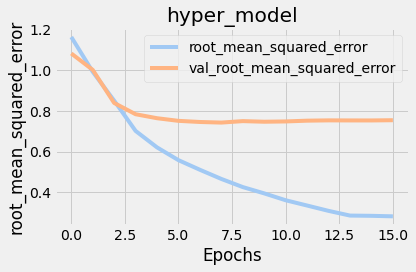

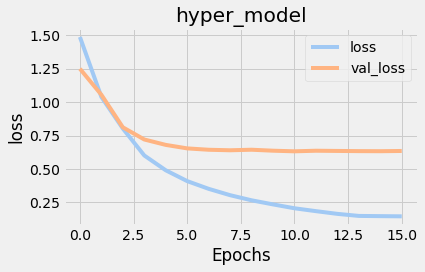

In [68]:
predict_complexity(hyper_model, test['excerpt'])
plot_graphs(history, "root_mean_squared_error", "hyper_model")
plot_graphs(history, "loss", "hyper_model")